In [1]:
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
import json
import time
import statistics
import re
from tabulate import tabulate
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [2]:
############################################################################
# Step 1: functions 
############################################################################

def calculate_mean_cost_range(cost_range):
    try:
        low, high = map(int, cost_range.split('-'))
        return (low + high) / 2
    except ValueError:
        return None

def train_and_evaluate_model(model, train_df, validation_df):
    X_train = train_df.drop(columns=['losses'])
    y_train = train_df['losses']
    X_val = validation_df.drop(columns=['losses'])
    y_val = validation_df['losses']

    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    predictions = np.clip(predictions, 0, None)
    mse = mean_squared_error(y_val, predictions)
    mae = mean_absolute_error(y_val, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val, predictions)
    
    return mse, mae, rmse, r2, predictions

def reverse_one_hot_encoding(df, prefix='state_'):
    return_df = df.copy()
    # Extract the one-hot encoded columns
    state_columns = [col for col in return_df.columns if col.startswith(prefix)]
    
    # Find the state name for each row
    return_df['state'] = return_df[state_columns].idxmax(axis=1).str.replace(prefix, '')
    
    # Drop the one-hot encoded columns
    return_df = return_df.drop(columns=state_columns)
    
    return return_df

def calculate_adjusted_capital_stock(row, cap_stock_df):
    if pd.isna(row['capital_stock_inflation_adjusted']):
        state = row['state']
        years_before_2013 = 2013 - row['year']
        new_cap_stock_series = cap_stock_df[cap_stock_df['state'] == state]['capital_stock_inflation_adjusted'] * (
            (1 - (cap_stock_df[cap_stock_df['state'] == state]['cap_stock_increase_per_year'] - 1)) ** years_before_2013
            )
        new_cap_stock = round(new_cap_stock_series.values[0] if not new_cap_stock_series.empty else None, 2).astype(float)
        print(new_cap_stock)
        return new_cap_stock
    return round(row['capital_stock_inflation_adjusted'], 2)

def calculate_permutation_importance(model, X_val, y_val):
    r = permutation_importance(model, X_val, y_val, n_repeats=30, random_state=0)
    importance_results = []
    for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
            importance_results.append({
                'Feature': X_val.columns[i],
                'Importance Mean': r.importances_mean[i],
                'Importance Std': r.importances_std[i]
            })
    return importance_results


def assess_multiple_models(models, train_df, validation_df, feature_importance=False):
    results = {}
    validation_df_orig_state = reverse_one_hot_encoding(validation_df)
    predictions_df = validation_df_orig_state[['state', 'year', 'losses']].copy()
    predictions_df.columns = ['state', 'year', 'actual']

    for model_name, model in models.items():
        mse, mae, rmse, r2, predictions = train_and_evaluate_model(model, train_df, validation_df)
        results[model_name] = {'MSE': mse, 'MAE': mae, 'RMSE': rmse, 'R2': r2}
        predictions_df[model_name] = predictions

        if feature_importance:
            importance_results = calculate_permutation_importance(model, validation_df.drop(columns=['losses']), validation_df['losses'])
            print(f"Permutation Importance for {model_name}:")
            for result in importance_results:
                print(f"{result['Feature']:<8} {result['Importance Mean']:.3f} +/- {result['Importance Std']:.3f}")
        
    return results, predictions_df


In [3]:
############################################################################
# Step 2: build training data from precipitation data and NOAA event data
############################################################################

states = ['fl', 'ga', 'ms', 'tx', 'al', 'la', 'sc', 'nc']
years = list(range(1983, 2024))
state_dfs = []

ml_training_df = pd.DataFrame(
    columns=['state', 'year', 'losses', 'tp_max_1d', 'tp_999_count', 'average_b_event_count', 'average_b_event_cost', 'b_event_count_last_year', 'average_b_event_count_last_10_years', 'event_count_increase_per_year', 'average_b_event_cost_last_10_years', 'average_b_event_cost_last_year', 'event_cost_increase_per_year', 'total_damages_last_5_years']
    )

for state in states:
    state_training_df = ml_training_df.copy()
    # max precipitation
    tp_max_df = pd.read_csv(f'../../../data/UNSEEN/hurricane/rainfall_preprocessed/states/ERA5_1d_monthly_max_{state.upper()}.csv')
    tp_max_df = tp_max_df[tp_max_df['year'] < 2024]
    tp_max_df = tp_max_df[tp_max_df['year'] > 1982]
    tp_max_df_grouped = tp_max_df.groupby('year').agg(
        max_monthly_max_tp=('tp', 'max'),
        min_monthly_max_tp=('tp', 'min'),
        mean_monthly_max_tp=('tp', 'mean'),
        sum_monthly_max_tp=('tp', 'sum')
    ).reset_index()
    tp_max_df_grouped['max_monthly_max_tp_last_5_years'] = tp_max_df_grouped['max_monthly_max_tp'].rolling(window=5, min_periods=1).max().fillna(0)
    tp_max_df_grouped['max_monthly_max_tp_last_10_years'] = tp_max_df_grouped['max_monthly_max_tp'].rolling(window=10, min_periods=1).max().fillna(0)

    # extreme precipitation frequency
    tp_freq_df = pd.read_csv(f'../../../data/UNSEEN/hurricane/rainfall_preprocessed/states/ERA5_999_counts_{state.upper()}.csv')
    tp_freq_df = tp_freq_df[tp_freq_df['year'] < 2024]
    tp_freq_df = tp_freq_df[tp_freq_df['year'] > 1982]
    tp_freq_df_grouped = tp_freq_df.groupby('year').agg(sum_999_tp=('tp', 'sum')).reset_index()
    tp_freq_df_grouped['sum_999_tp_last_5_years'] = tp_freq_df_grouped['sum_999_tp'].rolling(window=5, min_periods=1).sum().fillna(0)
    tp_freq_df_grouped['sum_999_tp_last_10_years'] = tp_freq_df_grouped['sum_999_tp'].rolling(window=10, min_periods=1).sum().fillna(0)
    
    # noaa event data
    noaa_df = pd.read_csv(f'../../../data/UNSEEN/hurricane/damages/noaa_damages/noaa_damages_{state.upper()}_tc.csv', skiprows=2)
    noaa_df = noaa_df[noaa_df['Year'] < 2024]
    noaa_df = noaa_df[noaa_df['Year'] > 1982]
    noaa_df = noaa_df.rename(columns={'Year': 'year'})
    noaa_df = noaa_df.rename(columns={'Tropical Cyclone Count': 'b_event_count'})
    noaa_df['losses'] = noaa_df['Tropical Cyclone Cost Range'].apply(calculate_mean_cost_range) # target variable
    noaa_df['losses_last_year'] = noaa_df['losses'].shift(1).fillna(0)
    noaa_df['losses_mean_last_5_years'] = noaa_df['losses'].shift(1).rolling(window=5, min_periods=1).mean().fillna(0)
    noaa_df['losses_mean_last_10_years'] = noaa_df['losses'].shift(1).rolling(window=10, min_periods=1).mean().fillna(0)
    noaa_df['losses_mean_total'] = noaa_df['losses'].shift(1).expanding().mean().fillna(0)
    noaa_df['losses_max_total'] = noaa_df['losses'].shift(1).expanding().max().fillna(0)
    noaa_df['b_event_count_last_year'] = noaa_df['b_event_count'].shift(1).fillna(0)
    noaa_df['average_b_event_count_last_5_years'] = noaa_df['b_event_count'].shift(1).rolling(window=5, min_periods=1).mean().fillna(0)
    noaa_df['average_b_event_count_last_10_years'] = noaa_df['b_event_count'].shift(1).rolling(window=10, min_periods=1).mean().fillna(0)
    noaa_df['b_event_count_max_total'] = noaa_df['b_event_count'].shift(1).expanding().max().fillna(0)
    noaa_df['average_b_event_cost_last_year'] = noaa_df['losses'].shift(1).fillna(0)
    noaa_df['average_b_event_cost_last_5_years'] = noaa_df['losses'].shift(1).rolling(window=5, min_periods=1).mean().fillna(0)
    noaa_df['average_b_event_cost_last_10_years'] = noaa_df['losses'].shift(1).rolling(window=10, min_periods=1).mean().fillna(0)
    noaa_df['b_event_cost_max_total'] = noaa_df['losses'].shift(1).expanding().max().fillna(0)
    noaa_df = noaa_df[['year', 'losses_last_year', 'losses_mean_last_5_years', 'losses_mean_last_10_years', 'losses_mean_total', 'losses_max_total', 
                       'b_event_count_last_year','average_b_event_count_last_5_years', 'average_b_event_count_last_10_years', 'b_event_count_max_total',
                       'average_b_event_cost_last_year', 'average_b_event_cost_last_5_years', 'average_b_event_cost_last_10_years', 'b_event_cost_max_total',
                        'losses']]    

    # era5 sea surface temperatures
    # https://climate.copernicus.eu/climate-indicators/sea-surface-temperature
    sst_df = pd.read_csv(f'../../../data/UNSEEN/hurricane/damages/sea_surface_temps/sea_surface_temps.csv')

    # merge data
    tp_merged_df = pd.merge(tp_max_df_grouped, tp_freq_df_grouped, on='year', how='inner')
    state_df = pd.merge(tp_merged_df, noaa_df, on='year', how='inner')
    state_sst_df = pd.merge(state_df, sst_df, on='year', how='inner')
    state_sst_df = state_sst_df.set_index('year').reindex(years).reset_index()
    state_sst_df['state'] = state
    state_sst_df['atlantic'] = 1 if state in ['fl', 'ga', 'sc', 'nc'] else 0
    state_sst_df['gulf'] = 1 if state in ['ms', 'tx', 'al', 'la', 'fl'] else 0
    state_dfs.append(state_sst_df)

ml_training_df = pd.concat(state_dfs, ignore_index=True)
ml_training_df.to_csv('../../../data/UNSEEN/hurricane/damages/preprocessed/ml_training_data.csv', index=False)

In [4]:
############################################################################
# Step 3: build state capital stock dataframe
############################################################################

directory = '../../../data/UNSEEN/hurricane/damages/county_exposure_files'
pattern = os.path.join(directory, '*-Data.csv')

dfs = []

cpi_df = pd.read_csv(
    '../../../data/UNSEEN/hurricane/damages/cpi.csv',
    dtype={'year': int, 'cpi': float}
)

# Loop through each file that matches the pattern
for file in glob.glob(pattern):
    match = re.search(r'ACSDP1Y(\d{4})\.DP04-Data\.csv', file)
    if match:
        year = match.group(1)
        try:
            df = pd.read_csv(file, usecols=["Geography", "Geographic Area Name", "Estimate!!HOUSING OCCUPANCY!!Total housing units", "Estimate!!VALUE!!Owner-occupied units!!Median (dollars)"], skiprows=1)
            df['year'] = year
            # Append the DataFrame to the list
            dfs.append(df)
        except ValueError as e:
            print(f"Column name not found in the file: {year}. Error: {e}")

#forgot alabama
al_directory = '../../../data/UNSEEN/hurricane/damages/county_exposure_files/alabama'
al_pattern = os.path.join(al_directory, '*-Data.csv')
al_dfs = []

for file in glob.glob(al_pattern):
    match = re.search(r'ACSDP1Y(\d{4})\.DP04-Data\.csv', file)
    if match:
        year = match.group(1)
        try:
            df = pd.read_csv(file, usecols=["Geography", "Geographic Area Name", "Estimate!!HOUSING OCCUPANCY!!Total housing units", "Estimate!!VALUE!!Owner-occupied units!!Median (dollars)"], skiprows=1)
            df['year'] = year
            # Append the DataFrame to the list
            al_dfs.append(df)
        except ValueError as e:
            print(f"Column name not found in the file: {year}. Error: {e}")


# Concatenate all DataFrames into one
counties_assets_df = pd.concat(dfs, ignore_index=True)
al_counties_assets_df = pd.concat(al_dfs, ignore_index=True)
all_counties_assets_df = pd.concat([counties_assets_df, al_counties_assets_df], ignore_index=True)

counties_assets_clean = all_counties_assets_df.rename(columns={'Geography': 'geo_id', 'Geographic Area Name': 'county_name', 'Estimate!!HOUSING OCCUPANCY!!Total housing units': 'housing_units', 'Estimate!!VALUE!!Owner-occupied units!!Median (dollars)': 'median_value'})
counties_assets_clean['state'] = counties_assets_clean['county_name'].str.extract(r', (.+)$')
counties_assets_clean['capital_stock'] = counties_assets_clean['housing_units'] * counties_assets_clean['median_value']
counties_assets_clean_filtered = counties_assets_clean[counties_assets_clean['state'] != 'Virginia']
counties_assets_clean_filtered = counties_assets_clean_filtered[counties_assets_clean_filtered['capital_stock'] > 0]
counties_assets_clean_filtered = counties_assets_clean_filtered[counties_assets_clean_filtered['capital_stock'].notna()]
counties_assets_grouped = counties_assets_clean_filtered.groupby(['state', 'year']).agg({'capital_stock': 'sum'}).reset_index()
counties_assets_grouped['year'] = counties_assets_grouped['year'].astype(int)
cpi_2023 = cpi_df[cpi_df['year'] == 2023]['cpi'].values[0]
merged_df = counties_assets_grouped.merge(cpi_df, on='year', how='left', suffixes=('', '_cpi'))
merged_df['capital_stock_inflation_adjusted'] = merged_df['capital_stock'] * (cpi_2023 / merged_df['cpi'])
state_assets = merged_df.drop(columns=['cpi'])
state_abbr_dict = {'Florida': 'fl', 'Georgia': 'ga', 'Mississippi': 'ms', 'Texas': 'tx','Louisiana': 'la', 'South Carolina': 'sc', 'North Carolina': 'nc', 'Virginia': 'va', 'Alabama': 'al'}
state_assets['state_abbr'] = state_assets['state'].map(state_abbr_dict)
state_assets = state_assets[['year', 'state_abbr', 'capital_stock_inflation_adjusted']]
state_assets = state_assets.rename(columns={'state_abbr': 'state'})

print(state_assets.head())
state_assets.to_csv('../../../data/UNSEEN/hurricane/damages/preprocessed/state_capital_stock.csv', index=False)


Column name not found in the file: 2011. Error: Usecols do not match columns, columns expected but not found: ['Estimate!!VALUE!!Owner-occupied units!!Median (dollars)']
Column name not found in the file: 2012. Error: Usecols do not match columns, columns expected but not found: ['Estimate!!VALUE!!Owner-occupied units!!Median (dollars)']
Column name not found in the file: 2010. Error: Usecols do not match columns, columns expected but not found: ['Estimate!!VALUE!!Owner-occupied units!!Median (dollars)']
Column name not found in the file: 2011. Error: Usecols do not match columns, columns expected but not found: ['Estimate!!VALUE!!Owner-occupied units!!Median (dollars)']
Column name not found in the file: 2012. Error: Usecols do not match columns, columns expected but not found: ['Estimate!!VALUE!!Owner-occupied units!!Median (dollars)']
Column name not found in the file: 2010. Error: Usecols do not match columns, columns expected but not found: ['Estimate!!VALUE!!Owner-occupied units!

In [5]:
############################################################################
# Step 4: merge ERA5 data, NOAA data, and state capital stock data. One-hot encode state
############################################################################

ml_training_cap_stock = ml_training_df.merge(state_assets, on = ['year', 'state'], how='left')

earliest_capital_stock_2013 = ml_training_cap_stock[ml_training_cap_stock['year'] == 2013][['capital_stock_inflation_adjusted', 'state']]
cap_stock_increase_per_year = pd.read_csv('../../../data/UNSEEN/hurricane/damages/preprocessed/state_cap_stock_increase.csv').drop(columns=['state'])
cap_stock_increase_per_year = cap_stock_increase_per_year.rename(columns={'state_abbr': 'state'})
cap_stock_df = cap_stock_increase_per_year.merge(earliest_capital_stock_2013, on='state', how='left')

# Apply the function to fill NaN values
ml_training_cap_stock['capital_stock_inflation_adjusted'] = ml_training_cap_stock.apply(
    calculate_adjusted_capital_stock, axis=1, args=(cap_stock_df,)
)

# one hot encode state
encoder = OneHotEncoder(sparse_output=False) #, drop='first')
encoded_states = encoder.fit_transform(ml_training_cap_stock[['state']])

# Create a DataFrame with the encoded states
encoded_states_df = pd.DataFrame(encoded_states, columns=encoder.get_feature_names_out(['state']))

# Concatenate the encoded states with the original DataFrame (excluding the original 'state' column)
ml_training_df_encoded = pd.concat([ml_training_cap_stock.drop(columns=['state']), encoded_states_df], axis=1)
ml_training_df_encoded.to_csv('../../../data/UNSEEN/hurricane/damages/preprocessed/ml_training_data_encoded.csv', index=False)

101390796463.46
111653156531.13
122954230543.58
135399152860.92
149103699111.5
164195363257.32
180814543675.69
199115849291.13
219269537908.64
241463100129.06
265903003581.97
292816613702.55
322454308921.71
355091809946.95
391032744803.59
430611473498.85
474196198586.87
522192390572.33
575046560019.37
633250411457.91
697345417731.21
767927857340.28
845654361647.41
931248023545.01
1025505124418.74
1129302541986.31
1243605907927.17
1369478591194.13
1508091590578.79
1660734428561.85
3591533782565.34
4796200923483.0
46231417998.3
50441126415.01
55034159542.94
60045421897.97
65512996307.18
71478433317.32
77987066956.04
85088359245.44
92836276086.16
101289697368.43
110512864426.67
120575868238.26
131555182076.17
143534242663.68
156604084247.37
170864030407.19
186422448860.73
203397574998.15
221918410405.79
242125703207.04
264173017670.34
288227901212.86
314473157668.36
343108236495.39
374350748483.03
408438119472.8
445629394663.91
486207207213.8
530479926094.04
578783999524.3
1162243199550.4

In [6]:
############################################################################
# Step 5: partition data into training, validation, and holdout sets
############################################################################

# Assuming ml_training_df is already loaded
years = ml_training_df_encoded['year'].unique()
years.sort()

# Define the splits
holdout_years = years[-5:]
training_years_1 = years[:-17]
training_years_2 = years[:-14]
training_years_3 = years[:-11]
training_years_4 = years[:-8]
validation_years_1 = years[-17:-14]
validation_years_2 = years[-14:-11]
validation_years_3 = years[-11:-8]
validation_years_4 = years[-8:-5]

print(f'Training years 1: {training_years_1[0]} - {training_years_1[-1]}')
print(f'Training years 2: {training_years_2[0]} - {training_years_2[-1]}')
print(f'Training years 3: {training_years_3[0]} - {training_years_3[-1]}')
print(f'Training years 4: {training_years_4[0]} - {training_years_4[-1]}')
print(f'Validation years 1: {validation_years_1[0]} - {validation_years_1[-1]}')
print(f'Validation years 2: {validation_years_2[0]} - {validation_years_2[-1]}')
print(f'Validation years 3: {validation_years_3[0]} - {validation_years_3[-1]}')
print(f'Validation years 4: {validation_years_4[0]} - {validation_years_4[-1]}')
print(f'Holdout years: {holdout_years[0]} - {holdout_years[-1]}')

# Create the splits
train_df_1 = ml_training_df_encoded[ml_training_df_encoded['year'].isin(training_years_1)]
train_df_2 = ml_training_df_encoded[ml_training_df_encoded['year'].isin(training_years_2)]
train_df_3 = ml_training_df_encoded[ml_training_df_encoded['year'].isin(training_years_3)]
train_df_4 = ml_training_df_encoded[ml_training_df_encoded['year'].isin(training_years_4)]
validation_df_1 = ml_training_df_encoded[ml_training_df_encoded['year'].isin(validation_years_1)]
validation_df_2 = ml_training_df_encoded[ml_training_df_encoded['year'].isin(validation_years_2)]
validation_df_3 = ml_training_df_encoded[ml_training_df_encoded['year'].isin(validation_years_3)]
validation_df_4 = ml_training_df_encoded[ml_training_df_encoded['year'].isin(validation_years_4)]
holdout_df = ml_training_df_encoded[ml_training_df_encoded['year'].isin(holdout_years)]
train_df_1

Training years 1: 1983 - 2006
Training years 2: 1983 - 2009
Training years 3: 1983 - 2012
Training years 4: 1983 - 2015
Validation years 1: 2007 - 2009
Validation years 2: 2010 - 2012
Validation years 3: 2013 - 2015
Validation years 4: 2016 - 2018
Holdout years: 2019 - 2023


,year,max_monthly_max_tp,min_monthly_max_tp,mean_monthly_max_tp,sum_monthly_max_tp,max_monthly_max_tp_last_5_years,max_monthly_max_tp_last_10_years,sum_999_tp,sum_999_tp_last_5_years,sum_999_tp_last_10_years,...,gulf,capital_stock_inflation_adjusted,state_al,state_fl,state_ga,state_la,state_ms,state_nc,state_sc,state_tx
0,1983,1.048223,0.321771,0.655752,3.278758,1.048223,1.048223,7,7.0,7.0,...,1,1.013908e+11,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1984,1.039019,0.213903,0.601714,3.008570,1.048223,1.048223,2,9.0,9.0,...,1,1.116532e+11,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1985,1.655964,0.483928,1.046894,5.234469,1.655964,1.655964,17,26.0,26.0,...,1,1.229542e+11,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1986,0.627574,0.320193,0.529858,2.649291,1.655964,1.655964,0,26.0,26.0,...,1,1.353992e+11,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1987,2.091622,0.378341,1.162058,5.810289,2.091622,2.091622,13,39.0,39.0,...,1,1.491037e+11,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306,2002,1.352332,0.360624,0.834441,4.172205,2.854478,2.854478,1,28.0,78.0,...,0,3.376421e+11,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
307,2003,2.629518,0.682603,1.583689,7.918444,2.854478,2.854478,12,27.0,90.0,...,0,3.623218e+11,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
308,2004,1.628020,0.543888,1.103713,5.518565,2.629518,2.854478,7,20.0,93.0,...,0,3.888055e+11,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
309,2005,1.468276,0.551216,1.105000,5.525001,2.629518,2.854478,2,22.0,73.0,...,0,4.172250e+11,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


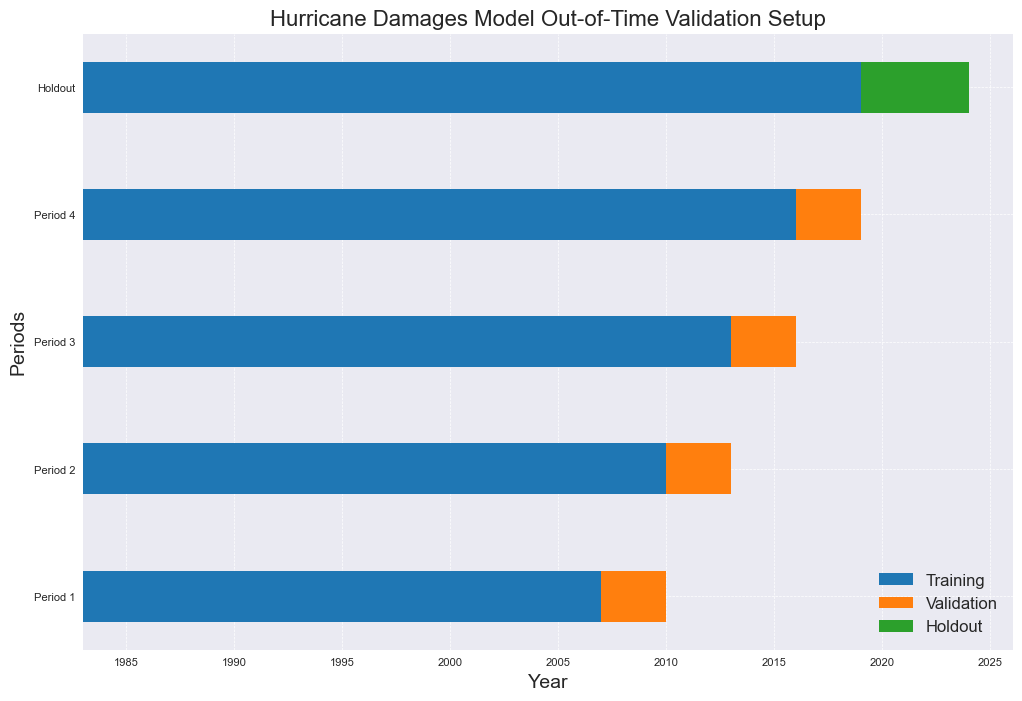

<Figure size 640x440 with 0 Axes>

In [24]:

## out of time validation plot


# import matplotlib.pyplot as plt

# # Check available styles
# plt.style.use('seaborn-v0_8-paper')


# # Define the periods
# periods = [
#     ('Training', training_years_1[0], training_years_1[-1]),
#     ('Validation', validation_years_1[0], validation_years_1[-1]),
#     ('Training', training_years_2[0], training_years_2[-1]),
#     ('Validation', validation_years_2[0], validation_years_2[-1]),
#     ('Training', training_years_3[0], training_years_3[-1]),
#     ('Validation', validation_years_3[0], validation_years_3[-1]),
#     ('Training', training_years_4[0], training_years_4[-1]),
#     ('Validation', validation_years_4[0], validation_years_4[-1]),
#     ('Holdout', holdout_years[0], holdout_years[-1])
# ]

# # Create the plot
# fig, ax = plt.subplots(figsize=(12, 8))

# # Define colors
# training_color = '#1f77b4'  # Blue
# validation_color = '#ff7f0e'  # Orange
# holdout_color = '#2ca02c'  # Green

# # Plot each period as a horizontal bar
# for i in range(0, len(periods) - 1, 2):
#     label_train, start_train, end_train = periods[i]
#     label_val, start_val, end_val = periods[i + 1]
#     ax.barh(i // 2, end_train - start_train + 1, left=start_train, height=0.4, align='center', color=training_color, label='Training' if i == 0 else "")
#     ax.barh(i // 2, end_val - start_val + 1, left=start_val, height=0.4, align='center', color=validation_color, label='Validation' if i == 0 else "")

# # Plot holdout period
# label_holdout, start_holdout, end_holdout = periods[-1]
# ax.barh(len(periods) // 2, end_holdout - start_holdout + 1, left=start_holdout, height=0.4, align='center', color=holdout_color, label='Holdout')

# # Plot the new training bar for the holdout row
# start_new_training = training_years_1[0]
# end_new_training = validation_years_4[-1]
# ax.barh(len(periods) // 2, end_new_training - start_new_training + 1, left=start_new_training, height=0.4, align='center', color=training_color, label='Training' if len(periods) // 2 == 0 else "")

# # Set the y-ticks and labels
# ax.set_yticks(range(len(periods) // 2 + 1))
# ax.set_yticklabels([f'Period {i + 1}' for i in range(len(periods) // 2)] + ['Holdout'])

# # Set the labels and title
# ax.set_xlabel('Year', fontsize=14)
# ax.set_ylabel('Periods', fontsize=14)
# ax.set_title('Hurricane Damages Model Out-of-Time Validation Setup', fontsize=16)
# ax.legend(fontsize=12)

# # Add grid lines
# ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# # Show the plot
# plt.show()
# plt.savefig('../../../figures/UNSEEN_hurricane/rainfall/technical_appendix/ml_validation_setup.png')

In [7]:
############################################################################
# Step 6: train and evaluate models
############################################################################

# Define models and hyperparameters
models = {
    'LinearRegression': LinearRegression(),
    'RFRegressor': RandomForestRegressor(n_estimators=50, max_depth=2, random_state=3),
    'XGBRegressor': XGBRegressor(learning_rate=0.1, n_estimators=50, max_depth=3, random_state=1),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'MLPRegressor': MLPRegressor(max_iter=1000)
}

# Best parameters found: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
#Best parameters found: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
#Best parameters found: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}


results_1, predictions_df_1 = assess_multiple_models(models, train_df_1, validation_df_1, feature_importance=False)
results_2, predictions_df_2 = assess_multiple_models(models, train_df_2, validation_df_2, feature_importance=False)
results_3, predictions_df_3 = assess_multiple_models(models, train_df_3, validation_df_3, feature_importance=False)
results_4, predictions_df_4 = assess_multiple_models(models, train_df_4, validation_df_4, feature_importance=False)

results = {}
results['validation_1'] = results_1
results['validation_2'] = results_2
results['validation_3'] = results_3
results['validation_4'] = results_4

predictions_df = pd.concat([predictions_df_1, predictions_df_2, predictions_df_3, predictions_df_4], ignore_index=True)

flattened_results = []
for validation_fold, models_results in results.items():
    for model_name, metrics in models_results.items():
        flattened_results.append({
            'Validation Fold': validation_fold,
            'Model': model_name,
            'MSE': metrics['MSE'],
            'MAE': metrics['MAE'],
            'RMSE': metrics['RMSE'],
            'R2': metrics['R2']
        })

results_df = pd.DataFrame(flattened_results)
results_df_ordered = results_df.sort_values(['Model', 'Validation Fold'], ascending=True).reset_index(drop=True)
print(results_df_ordered[results_df_ordered['Model'] == 'RFRegressor'])
print('Mean RMSE:', results_df_ordered[results_df_ordered['Model'] == 'RFRegressor']['RMSE'].mean())
#predictions_df.to_csv('../../../data/UNSEEN/hurricane/damages/preprocessed/validation_fold_predictions.csv', index=False)


Permutation Importance for LinearRegression:
losses_mean_total 3.669 +/- 0.896
sum_999_tp_last_5_years 3.383 +/- 0.994
losses_mean_last_10_years 2.867 +/- 1.030
average_b_event_cost_last_10_years 2.867 +/- 1.030
average_b_event_count_last_10_years 1.147 +/- 0.526
b_event_count_max_total 0.785 +/- 0.245
average_b_event_count_last_5_years 0.533 +/- 0.257
state_la 0.352 +/- 0.102
losses_mean_last_5_years 0.143 +/- 0.063
average_b_event_cost_last_5_years 0.143 +/- 0.063
Permutation Importance for RFRegressor:
Permutation Importance for XGBRegressor:
Permutation Importance for GradientBoostingRegressor:
sum_999_tp 0.309 +/- 0.104
losses_mean_total 0.235 +/- 0.105
losses_mean_last_5_years 0.005 +/- 0.002
Permutation Importance for MLPRegressor:
state_ms 0.142 +/- 0.065
state_tx 0.022 +/- 0.008
Permutation Importance for LinearRegression:
losses_mean_last_10_years 161.948 +/- 41.558
average_b_event_cost_last_10_years 161.944 +/- 41.558
sum_999_tp_last_5_years 82.800 +/- 26.738
average_b_event

In [8]:
############################################################################
# Optional: optimization
############################################################################

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error

# Define the parameter grid
param_grid = {
    'n_estimators': [10, 50, 75, 100],
    'max_depth': [2, 3, 5, 10],
    'max_features': [None, 'sqrt', 'log2']
}

# Define the model
rf = RandomForestRegressor()

# Define the scoring function
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

training_df = ml_training_df_encoded[~ml_training_df_encoded['year'].isin(holdout_years)]

# Perform the grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring=rmse_scorer, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(training_df.drop(columns=['losses']), training_df['losses'])

# Get the best parameters and the corresponding RMSE
best_params = grid_search.best_params_
best_rmse = -grid_search.best_score_

print(f"Best parameters found: {best_params}")
print(f"Best RMSE: {best_rmse}")

best_rf = RandomForestRegressor(**best_params)
best_rf.fit(training_df.drop(columns=['losses']), training_df['losses'])

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END ....max_depth=2, max_features=None, n_estimators=10; total time=   0.0s
[CV] END ....max_depth=2, max_features=None, n_estimators=10; total time=   0.0s
[CV] END ....max_depth=2, max_features=None, n_estimators=10; total time=   0.0s
[CV] END ....max_depth=2, max_features=None, n_estimators=75; total time=   0.1s
[CV] END ....max_depth=2, max_features=None, n_estimators=50; total time=   0.0s
[CV] END ....max_depth=2, max_features=None, n_estimators=50; total time=   0.0s
[CV] END ....max_depth=2, max_features=sqrt, n_estimators=10; total time=   0.0s
[CV] END ...max_depth=2, max_features=None, n_estimators=100; total time=   0.1s
[CV] END ....max_depth=2, max_features=sqrt, n_estimators=10; total time=   0.0s
[CV] END ....max_depth=2, max_features=None, n_estimators=50; total time=   0.0s
[CV] END ....max_depth=2, max_features=sqrt, n_estimators=10; total time=   0.0s
[CV] END ....max_depth=2, max_features=sqrt, n_

RandomForestRegressor(max_depth=5, max_features='log2', n_estimators=75)

In [10]:
############################################################################
# Step 7: train and evaluate on holdout set
############################################################################

# Combine the training data and validation sets into a single training set
holdout_validation = ml_training_df_encoded[ml_training_df_encoded['year'].isin(holdout_years)]
holdout_training = ml_training_df_encoded[~ml_training_df_encoded['year'].isin(holdout_years)]

holdout_training_orig_state = reverse_one_hot_encoding(holdout_validation)
holdout_predictions_df = holdout_training_orig_state[['state', 'year', 'losses']].copy()
holdout_predictions_df.columns = ['state', 'year', 'actual']

# Retrain the RandomForestRegressor on the combined training data
model = RandomForestRegressor(n_estimators=50, max_depth=2, random_state=2)
#model = RandomForestRegressor(n_estimators=100, max_depth=2, max_features='sqrt', random_state=1)

# model = XGBRegressor(n_estimators=100, max_depth=2)
# model = LinearRegression()

holdout_results, holdout_predictions_df = assess_multiple_models({'RFRegressor': model}, holdout_training, holdout_validation, feature_importance=False)
holdout_results = holdout_results['RFRegressor']

# Display the comparison table and accuracy metrics
print(f'Mean Squared Error (MSE): {holdout_results['MSE']}')
print(f'Mean Absolute Error (MAE): {holdout_results['MAE']}')
print(f'R-squared (R2): {holdout_results['R2']}')  
print(f'Root Mean Squared Error (RMSE): {holdout_results['RMSE']}')
print(holdout_predictions_df.groupby(['state']).agg({'actual': 'sum', 'RFRegressor': 'sum'}))

holdout_actual_losses = holdout_predictions_df["actual"].sum()
holdout_predicted_losses = holdout_predictions_df["RFRegressor"].sum()
print(f'Total actual holdout losses: ${holdout_actual_losses:,.0f}')
print(f'Total predicted holdout losses: ${holdout_predicted_losses:,.0f}')

#holdout_validation.to_csv('../../../data/UNSEEN/hurricane/damages/preprocessed/holdout_validation_data.csv', index=False)
#holdout_predictions_df.to_csv('../../../data/UNSEEN/hurricane/damages/preprocessed/holdout_predictions.csv', index=False)

Permutation Importance for RFRegressor:
state_fl 0.019 +/- 0.005
losses_mean_last_5_years 0.014 +/- 0.005
b_event_count_last_year 0.010 +/- 0.003
Mean Squared Error (MSE): 824009607.7793415
Mean Absolute Error (MAE): 12781.492439609361
R-squared (R2): -0.21021456818769102
Root Mean Squared Error (RMSE): 28705.567539753356
         actual    RFRegressor
state                         
al       7675.0    6527.646126
fl     162125.0   49355.779515
ga       4852.5    8354.037778
la     110052.5   20941.201077
ms       1875.0   44043.471595
nc       4675.0    8953.298789
sc       2477.5    7026.006416
tx      11750.0  189273.501295
Total actual holdout losses: $305,482
Total predicted holdout losses: $334,475


In [395]:
############################################################################
# Step 8: Plots
############################################################################

# Predicted vs Actual

validation_folds = pd.read_csv('../../../data/UNSEEN/hurricane/damages/preprocessed/validation_fold_predictions.csv')
validation_folds = validation_folds[['year', 'state', 'RFRegressor', 'actual']]

holdout = pd.read_csv('../../../data/UNSEEN/hurricane/damages/preprocessed/holdout_predictions.csv')

combined_df = pd.concat([validation_folds, holdout], ignore_index=True)

combined_grouped_df = combined_df.groupby(['year']).agg({'RFRegressor': 'sum', 'actual': 'sum'}).reset_index()
combined_grouped_df

# Assuming 'combined_grouped_df' has columns 'year', 'RandomForestRegressor', and 'actual'
fig = px.line(combined_grouped_df, x='year', y=['RFRegressor', 'actual'], 
              title='Actual vs Predicted Losses Over Time')

# Update layout for better readability
fig.update_layout(
    xaxis_title='Year',
    yaxis_title='Losses',
    legend_title='Legend'
)

# fig.show()
# fig.write_image('../../../figures/UNSEEN_hurricane/rainfall/technical_appendix/losses_model_predicted_vs_actual.png')

# Residuals


In [10]:
############################################################################
# Create multiplier df to create future data
############################################################################

columns_of_interest = ['year', 'max_monthly_max_tp', 'sum_999_tp', 
                       'b_event_count_last_year', 'average_b_event_cost_last_year', 
                       'capital_stock_inflation_adjusted']

state_columns = ['state_al', 'state_fl', 'state_ga', 'state_la', 'state_ms', 'state_nc', 'state_sc', 'state_tx']
def calculate_average_increase(group):
    result = {}
    for col in columns_of_interest[1:]:  # Skip 'year'
        # Calculate the slope of the linear regression line (average increase per year)
        first_15_year_mean = group[group['year'].isin(group['year'].unique()[:15])][col].mean()
        last_15_year_mean = group[group['year'].isin(group['year'].unique()[-15:])][col].mean()
        average_increase = ((last_15_year_mean - first_15_year_mean) / first_15_year_mean) / group['year'].nunique()
        result[col] = average_increase
    return pd.Series(result)

# Initialize an empty DataFrame to store results
multiplier_df = pd.DataFrame()

# Loop through each state column
for state_col in state_columns:
    # Filter the DataFrame for the current state
    state_df = ml_training_df_encoded[ml_training_df_encoded[state_col] == 1]
    
    # Group by year and calculate the average increase
    state_result = calculate_average_increase(state_df)
    
    # Add the state column to the result
    state_result['state'] = state_col.replace('state_', '')
    
    # Append the result to the multiplier_df
    multiplier_df = pd.concat([multiplier_df, state_result.to_frame().T], ignore_index=True)

# Reorder columns to have 'state' first
multiplier_df = multiplier_df[['state'] + columns_of_interest[1:]]

print(multiplier_df.head())

  state max_monthly_max_tp sum_999_tp b_event_count_last_year  \
0    al          -0.000183  -0.002673                0.039024   
1    fl           0.002081   0.005998                 0.03252   
2    ga          -0.000928  -0.007265                0.170732   
3    la           0.007507   0.037073                 0.04878   
4    ms           0.010748   0.027825                0.030488   

  average_b_event_cost_last_year capital_stock_inflation_adjusted  
0                       0.081494                         0.066859  
1                        0.04292                         0.260694  
2                       0.094756                         0.196114  
3                       0.378603                          0.01309  
4                       0.025742                         0.032654  


In [11]:
############################################################################
# Step 9: prepare future prediction data for next 5 years
############################################################################

def create_future_features(most_recent_value, percent_increase_per_year, years=1):
    future_value = most_recent_value * ((1 + percent_increase_per_year) ** years)
    return future_value

# noaa_era5_census = pd.read_csv('../../../data/UNSEEN/hurricane/damages/preprocessed/noaa_era5_census_legacy.csv')

# multiplier_df = noaa_era5_census[['state', 'tp_increase_per_year_percent', 'tp_freq_increase_per_year_percent', 'event_count_increase_per_year', 
#                                   'event_cost_increase_per_year', 'cap_stock_increase_per_year']]
# multiplier_df = multiplier_df.rename(columns={'tp_increase_per_year_percent': 'max_monthly_max_tp', 'tp_freq_increase_per_year_percent': 'sum_999_tp',
#                                                'event_count_increase_per_year': 'b_event_count_last_year',
#                                                  'event_cost_increase_per_year': 'average_b_event_cost_last_year', 
#                                                  'cap_stock_increase_per_year': 'capital_stock_inflation_adjusted'})

future_years = range(2024, 2029)

future_rows = []

future_df = ml_training_cap_stock[ml_training_cap_stock['year'].isin(holdout_years)]
most_recent_data = future_df[future_df['year'] == 2023]
most_recent_5_years = future_df[future_df['year'] > 2018]
for state in most_recent_data['state'].unique():
    state_data = most_recent_5_years[most_recent_5_years['state'] == state]
    percent_increase_data = multiplier_df[multiplier_df['state'] == state]
    for year in future_years:
        future_row = {'state': state, 'year': year}
        
        for feature in percent_increase_data.columns.tolist()[1:]:
            percent_increase_per_year = percent_increase_data[feature].values[0]
            most_recent_value = state_data[feature].values.mean()
            # Calculate future value for the given year
            years_ahead = year - 2023
            future_value = create_future_features(most_recent_value, percent_increase_per_year, years=years_ahead)
            # Add the future value to the row
            future_row[feature] = future_value
        
        future_row['average_b_event_cost_last_10_years'] = most_recent_5_years[most_recent_5_years['state'] == state]['average_b_event_cost_last_10_years'].mean()
        future_row['average_b_event_count_last_10_years'] = most_recent_5_years[most_recent_5_years['state'] == state]['average_b_event_count_last_10_years'].mean()
        future_row['mean_monthly_max_tp'] = most_recent_5_years[most_recent_5_years['state'] == state]['mean_monthly_max_tp'].mean()
        future_row['sum_monthly_max_tp'] = most_recent_5_years[most_recent_5_years['state'] == state]['sum_monthly_max_tp'].mean()
        future_row['min_monthly_max_tp'] = most_recent_5_years[most_recent_5_years['state'] == state]['min_monthly_max_tp'].mean()
        future_row['sum_999_tp_last_5_years'] = most_recent_5_years[most_recent_5_years['state'] == state]['sum_999_tp_last_5_years'].mean()
        future_row['sum_999_tp_last_10_years'] = most_recent_5_years[most_recent_5_years['state'] == state]['sum_999_tp_last_10_years'].mean()
        future_row['max_monthly_max_tp_last_5_years'] = most_recent_5_years[most_recent_5_years['state'] == state]['max_monthly_max_tp_last_5_years'].mean()
        future_row['max_monthly_max_tp_last_10_years'] = most_recent_5_years[most_recent_5_years['state'] == state]['max_monthly_max_tp_last_10_years'].mean()
        future_row['b_event_count_last_year'] = most_recent_5_years[most_recent_5_years['state'] == state]['b_event_count_last_year'].mean()
        future_row['average_b_event_cost_last_year'] = most_recent_5_years[most_recent_5_years['state'] == state]['average_b_event_cost_last_year'].mean()
        future_row['average_b_event_count_last_5_years'] = most_recent_5_years[most_recent_5_years['state'] == state]['average_b_event_count_last_5_years'].mean()
        future_row['average_b_event_cost_last_5_years'] = most_recent_5_years[most_recent_5_years['state'] == state]['average_b_event_cost_last_5_years'].values[0]
        future_row['sst'] = most_recent_data[most_recent_data['state'] == state]['sst'].values[0]
        future_row['losses_last_year'] = most_recent_5_years[most_recent_5_years['state'] == state]['losses_last_year'].mean()
        future_row['losses_mean_last_5_years'] = most_recent_5_years[most_recent_5_years['state'] == state]['losses_mean_last_5_years'].mean()
        future_row['losses_mean_last_10_years'] = most_recent_5_years[most_recent_5_years['state'] == state]['losses_mean_last_10_years'].mean()
        future_row['losses_mean_total'] = most_recent_5_years[most_recent_5_years['state'] == state]['losses_mean_total'].mean()
        future_row['losses_max_total'] = most_recent_5_years[most_recent_5_years['state'] == state]['losses_max_total'].max()
        future_row['b_event_count_max_total'] = most_recent_5_years[most_recent_5_years['state'] == state]['b_event_count_max_total'].max()
        future_row['b_event_cost_max_total'] = most_recent_5_years[most_recent_5_years['state'] == state]['b_event_cost_max_total'].max()
        future_row['atlantic'] = 1 if state in ['fl', 'ga', 'sc', 'nc'] else 0
        future_row['gulf'] = 1 if state in ['ms', 'tx', 'al', 'la', 'fl'] else 0

        # Append the row to the future_df
        future_rows.append(future_row)

future_df = pd.DataFrame(future_rows)
encoded_states = encoder.fit_transform(future_df[['state']])
encoded_states_df = pd.DataFrame(encoded_states, columns=encoder.get_feature_names_out(['state']))
future_df_encoded = pd.concat([future_df.drop(columns=['state']), encoded_states_df], axis=1)

# Concatenate the encoded states with the original DataFrame (excluding the original 'state' column)
# for state in future_df['state'].unique():

#     future_df_encoded['average_b_event_cost_last_10_years'] = most_recent_5_years['average_b_event_cost_last_10_years'].mean()
#     future_df_encoded['average_b_event_count_last_10_years'] = most_recent_5_years['average_b_event_count_last_10_years'].mean()
#     future_df_encoded['mean_monthly_max_tp'] = most_recent_5_years['mean_monthly_max_tp'].mean()
#     future_df_encoded['sum_monthly_max_tp'] = most_recent_5_years['sum_monthly_max_tp'].mean()
#     future_df_encoded['min_monthly_max_tp'] = most_recent_5_years['min_monthly_max_tp'].mean()
#     future_df_encoded['sum_999_tp_last_5_years'] = most_recent_5_years['sum_999_tp_last_5_years'].mean()
#     future_df_encoded['sum_999_tp_last_10_years'] = most_recent_5_years['sum_999_tp_last_10_years'].mean()
#     future_df_encoded['max_monthly_max_tp_last_5_years'] = most_recent_5_years['max_monthly_max_tp_last_5_years'].mean()
#     future_df_encoded['max_monthly_max_tp_last_10_years'] = most_recent_5_years['max_monthly_max_tp_last_10_years'].mean()
#     future_df_encoded['b_event_count_last_year'] = most_recent_5_years['b_event_count_last_year'].mean()
#     future_df_encoded['average_b_event_cost_last_year'] = most_recent_5_years['average_b_event_cost_last_year'].mean()
#     future_df_encoded['average_b_event_count_last_5_years'] = most_recent_5_years['average_b_event_count_last_5_years'].mean()
#     future_df_encoded['average_b_event_cost_last_5_years'] = most_recent_5_years['average_b_event_cost_last_5_years'].values[0]
#     future_df_encoded['sst'] = most_recent_data['sst'].values[0]
#     future_df_encoded['losses_last_year'] = most_recent_5_years['losses'].mean()
#     future_df_encoded['losses_last_5_years'] = most_recent_5_years['losses_last_5_years'].mean()
#     future_df_encoded['losses_last_10_years'] = most_recent_5_years['losses_last_10_years'].mean()
#     future_df_encoded['losses_mean_total'] = most_recent_5_years['losses_mean_total'].mean()

future_df_encoded = future_df_encoded[
    ml_training_df_encoded.drop(columns=['losses']).columns.tolist()
    ]
#future_df_encoded.to_csv('../../../data/UNSEEN/hurricane/damages/preprocessed/future_data_new.csv', index=False)

In [12]:
############################################################################
# Step 10: make future predictions and calculate total expected losses
############################################################################

#model = RandomForestRegressor(n_estimators=100, max_depth=3, max_features='sqrt', random_state=1)
model = RandomForestRegressor(n_estimators=50, max_depth=2, random_state=3)

#model = XGBRegressor(learning_rate=0.1, n_estimators=50, max_depth=3)
#model = LinearRegression()

model.fit(ml_training_df_encoded.drop(columns=['losses']), ml_training_df_encoded['losses'])

y_pred = model.predict(future_df_encoded)
y_pred = np.clip(y_pred, 0, None)

# Add predictions to the DataFrame
future_predictions = future_df_encoded.copy()
future_predictions['Predicted_Losses'] = y_pred

# Calculate the total expected losses across all states for the next 5 years
total_expected_losses = future_predictions['Predicted_Losses'].sum()

# Print the total expected losses
print(f'Total Expected Losses in the Next 5 Years Across All States: ${total_expected_losses:,.0f}')
# print(f'Total actual holdout losses: ${holdout_predictions_df["actual"].sum():,.0f}')

# Identify the one-hot encoded state columns
state_columns = [col for col in future_predictions.columns if col.startswith('state_')]

# Calculate total losses per state
total_losses_per_state = []
for state_col in state_columns:
    state_name = state_col.replace('state_', '')
    total_loss = future_predictions.loc[future_predictions[state_col] == 1, 'Predicted_Losses'].sum()
    total_losses_per_state.append({'state': state_name, 'Total_Losses': total_loss})

# Convert the list to a DataFrame
total_losses_per_state_df = pd.DataFrame(total_losses_per_state)

# Print the table with total losses per state
print("Total Expected Losses per State in the Next 5 Years:")
print(total_losses_per_state_df)
#future_predictions.to_csv('../../../data/UNSEEN/hurricane/damages/preprocessed/future_predictions.csv', index=False)

Total Expected Losses in the Next 5 Years Across All States: $489,202
Total Expected Losses per State in the Next 5 Years:
  state   Total_Losses
0    al    7350.364543
1    fl  237201.878974
2    ga    7993.651096
3    la   17793.364764
4    ms    8923.520858
5    nc    7350.364543
6    sc    7350.364543
7    tx  195238.465841


In [13]:
increase = 450000 - holdout_actual_losses
percent_increase = (450000 - holdout_actual_losses) / holdout_actual_losses * 100
print(percent_increase)

47.307947263754876
